In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False

FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/Kolmogorov


In [7]:
from tools.misc_tools import mytimecallback, SaveLosses, plot_losses, readAndReturnLossHistories
from tools.ae_v11 import Autoencoder

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2023-06-15 23:52:06.934726: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-06-15 23:52:06.935139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-15 23:52:07.016953: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-15 23:52:07.017476: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-15 23:52:07.017905: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-15 23:52:07.018306: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # loading data directory
    data_dir_idx = '000'

    # making ae save directory
    dir_name_ae = os.getcwd() + dir_sep + 'saved_ae'
    if not os.path.isdir(dir_name_ae):
        os.makedirs(dir_name_ae)

    counter = 0
    while True:
        dir_check = 'ae_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ae + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ae = dir_name_ae + dir_sep + dir_check
    os.makedirs(dir_name_ae)
    os.makedirs(dir_name_ae+dir_sep+'plots')
else:
    # some paramaters
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_015'.format(ds=dir_sep)

    with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))
    data_dir_idx = params_dict['data_dir_idx']
    normalizeforae_flag = params_dict['normalizeforae_flag']
    normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
    if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_ae:', dir_name_ae)
# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with h5py.File(dir_name_data + '/data.h5', 'r') as f:
    t_recorded_samples = np.array(f['t'])
    
    N = int(0.5*(np.array(f['num_wavenumbers'])-1))
    print(N, type(N))
    
    u_ref = np.array(f['u_reference'], dtype=FTYPE)
    v_ref = np.array(f['v_reference'], dtype=FTYPE)

dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_052
24 <class 'int'>


In [13]:
all_data = np.empty(shape=(u_ref.shape[0], 2, u_ref.shape[1], u_ref.shape[2]), dtype=FTYPE)
all_data[:, 0, :, :] = u_ref
del(u_ref)
all_data[:, 1, :, :] = v_ref
del(v_ref)

In [14]:
# dealing with normalizing the data before feeding into autoencoder
if behaviour == 'initialiseAndTrainFromScratch':
    # normalize data before feeding into autoencoder?
    normalizeforae_flag = True
    normalization_type = 'stddev' # could be 'stddev' or 'minmax'
    stddev_multiplier = 3
    
    normalization_constant_arr_aedata = None
    if normalizeforae_flag == True:
        normalization_constant_arr_aedata = np.empty(shape=(2,) + tuple(all_data.shape[1:]), dtype=FTYPE)
        if normalization_type == 'stddev':
            normalization_constant_arr_aedata[0] = np.mean(all_data, axis=0)
            normalization_constant_arr_aedata[1] = stddev_multiplier * np.std(all_data, axis=0)
        elif normalization_type == 'minmax':
            sample_min = all_data.min(axis=0)
            sample_max = all_data.max(axis=0)
            idx = np.where(sample_min == sample_max)
            if len(idx) > 0:
                num_elems = len(idx[0])
                for i in range(num_elems):
                    i0 = idx[0][i]
                    i1 = idx[1][i]
                    i2 = idx[2][i]
                    sample_min[i0, i1, i2] -= 0.5
                    sample_max[i0, i1, i2] = sample_min[i0, i1, i2] + 1.
            normalization_constant_arr_aedata[0] = sample_min
            normalization_constant_arr_aedata[1] = sample_max - sample_min
        all_data -= normalization_constant_arr_aedata[0]
        all_data /= normalization_constant_arr_aedata[1]
            
    # saving sim data
    ae_data = {
        'data_dir_idx':data_dir_idx,
        'normalizeforae_flag':normalizeforae_flag,
        # 'normalization_constant_arr_aedata':normalization_constant_arr_aedata,
        'normalization_type':normalization_type,
        'stddev_multiplier':stddev_multiplier,
        'ae_data_with_params':False,
        'module':Autoencoder.__module__,
    }
    with open(dir_name_ae+dir_sep+'ae_data.txt', 'w') as f:
        f.write(str(ae_data))
    np.savez(
        dir_name_ae+dir_sep+'normalization_data',
        normalization_constant_arr_aedata=[normalization_constant_arr_aedata],
    )
else:
    if normalizeforae_flag == True:
        all_data -= normalization_constant_arr_aedata[0]
        all_data /= normalization_constant_arr_aedata[1]
            
time_stddev = np.std(all_data, axis=0)

In [15]:
all_data = all_data[::4]

# Autoencoder

In [16]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [1e-3, 1e-4, 1e-5]
    epochs = 200
    patience = 10  # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 5e-7 # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 16
    fRMS = 2/100
    timeMeanofSpaceRMS = np.mean(np.mean(all_data**2, axis=1)**0.5)
    
    # stddev = fRMS*timeMeanofSpaceRMS
    stddev = fRMS * np.mean(time_stddev)
    use_weights_post_dense = False
    use_batch_norm = True

    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
        'use_batch_norm':use_batch_norm,
    }

    with open(dir_name_ae+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
else:
    with open(dir_name_ae + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        stddev = tparams_dict['stddev']
    except:
        print("'stddev' not in tparams_dict, set to 0")
        stddev = 0.0

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [17]:
# # setting up data
# idx = np.arange(all_data.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round((1-test_split)*all_data.shape[0]))
# training_data = all_data[idx[0:boundary], :]
# testing_data = all_data[idx[boundary:], :]

In [18]:
num_train = int(all_data.shape[0]*train_split)
num_val = int(all_data.shape[0]*val_split)
num_test = all_data.shape[0] - num_train - num_val

idx = np.arange(all_data.shape[0])
np.random.shuffle(idx)

training_data = np.empty(shape=(num_train, ) + tuple(all_data.shape[1:]), dtype=FTYPE)
val_data = np.empty(shape=(num_val, ) + tuple(all_data.shape[1:]), dtype=FTYPE)
testing_data = np.empty(shape=(num_test, ) + tuple(all_data.shape[1:]), dtype=FTYPE)

training_data[:] = all_data[idx[0:num_train]]
val_data[:] = all_data[idx[num_train:num_train+num_val]]
testing_data[:] = all_data[idx[num_train+num_val:]]

In [19]:
del(all_data)

In [20]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    enc_filters = [8, 16, 32, 10, 4]  # [8, 12, 6, 1] # [8, 3, 1]
    enc_strides = [2, 2, 2, 2, 1] # [3, 2, 2, 1] # [2, 1, 1]
    enc_attn_placement = [1, 2, 3]
    dec_filters = [10, 32, 16, 8, 2] # [6, 12, 8, 2] # [3, 8, 2]
    dec_strides = [1, 2, 2, 2, 2] # [1, 2, 2, 3] # [1, 1, 2]
    dec_attn_placement = [0, 1]
    kernel_size = [3, 5, 7]
    ls_dim = 0
    
    enc_layer_act_func = 'elu'
    enc_final_layer_act_func = 'tanh'
    dec_layer_act_func = 'elu'
    dec_final_layer_act_func = 'tanh'
    reg_name = 'L2'
    
    use_periodic_padding = True
    use_attention_module = True
    
    if strategy is not None:
        with strategy.scope():
            ae_net = Autoencoder(
                data_dim=training_data.shape[1:],
                kernel_size=kernel_size,
                enc_filters=enc_filters, # number of filters
                dec_filters=dec_filters, # number of filters
                lambda_reg=lambda_reg,
                reg_name=reg_name,
                enc_layer_act_func=enc_layer_act_func,
                enc_final_layer_act_func=enc_final_layer_act_func,
                dec_layer_act_func=dec_layer_act_func,
                dec_final_layer_act_func=dec_final_layer_act_func,
                load_file=None,
                stddev=stddev,
                use_weights_post_dense=use_weights_post_dense,
                use_batch_norm=use_batch_norm,
                use_periodic_padding=use_periodic_padding,
                use_attention_module=use_attention_module,
                enc_strides=enc_strides,
                enc_attn_placement=enc_attn_placement,
                dec_strides=dec_strides,
                dec_attn_placement=dec_attn_placement,
                ls_dim=ls_dim,)
    else:
        ae_net = Autoencoder(
            data_dim=training_data.shape[1:],
            kernel_size=kernel_size,
            enc_filters=enc_filters, # number of filters
            dec_filters=dec_filters, # number of filters
            lambda_reg=lambda_reg,
            reg_name=reg_name,
            enc_layer_act_func=enc_layer_act_func,
            enc_final_layer_act_func=enc_final_layer_act_func,
            dec_layer_act_func=dec_layer_act_func,
            dec_final_layer_act_func=dec_final_layer_act_func,
            load_file=None,
            stddev=stddev,
            use_weights_post_dense=use_weights_post_dense,
            use_batch_norm=use_batch_norm,
            use_periodic_padding=use_periodic_padding,
            use_attention_module=use_attention_module,
            enc_strides=enc_strides,
            enc_attn_placement=enc_attn_placement,
            dec_strides=dec_strides,
            dec_attn_placement=dec_attn_placement,
            ls_dim=ls_dim,)
    # saving the AE configuration
    save_path = dir_name_ae+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    ae_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_ae + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            ae_net = Autoencoder(data_dim=training_data.shape[1:], load_file=load_file)
    else:
        ae_net = Autoencoder(data_dim=training_data.shape[1:], load_file=load_file)
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_ae+dir_sep+'checkpoints')
        # ae_net.load_weights(wt_file)
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'
        ae_net.load_weights_from_file(wt_file)

enc_elem_spatial_dims :  [[TensorShape([50, 50]), (24, 24), (12, 12), (6, 6), (3, 3), (3, 3)], [TensorShape([50, 50]), (24, 24), (12, 12), (6, 6), (3, 3), (3, 3)], [TensorShape([50, 50]), (24, 24), (12, 12), (6, 6), (3, 3), (3, 3)]]
dec_elem_spatial_dims :  [[TensorShape([3, 3])], [TensorShape([3, 3])], [TensorShape([3, 3])]]


2023-06-15 23:52:18.887242: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401


In [21]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt = readAndReturnLossHistories(
        dir_name_ae=dir_name_ae,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_ae+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [22]:
train_MSE_hist = []
val_MSE_hist = []

train_NMSE_hist = []
val_NMSE_hist = []

if use_attention_module == True:
    encoder_attention_lambdas = {}
    decoder_attention_lambdas = {}
    for ks_i in range(len(ae_net.kernel_size)):
        for i in range(len(ae_net.encoder_attention_modules_list[ks_i])):
            # l = ae_net.encoder_attention_modules_list[i]
            encoder_attention_lambdas['{}__encoder_attention_module_{}_lambda'.format(ks_i, i)] = [0]
        for i in range(len(ae_net.decoder_attention_modules_list[ks_i])):
            # l = ae_net.decoder_attention_modules_list[i]
            decoder_attention_lambdas['{}__decoder_attention_module_{}_lambda'.format(ks_i, i)] = [0]

In [23]:
class NMSE(tf.keras.metrics.MeanSquaredError):
    def __init__(self, divisor_arr, name='NMSE', **kwargs):
        super(NMSE, self).__init__(name, **kwargs)
        self.divisor_arr = divisor_arr

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true / self.divisor_arr
        y_pred = y_pred / self.divisor_arr
        return super(NMSE, self).update_state(y_true, y_pred, sample_weight)

In [24]:
if strategy is not None:
    with strategy.scope():
        NMSE_metric = NMSE(divisor_arr=tf.constant(time_stddev))
else:
    NMSE_metric = NMSE(divisor_arr=tf.constant(time_stddev))

In [25]:
# compiling the network
ae_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
#     loss=losses.BinaryCrossentropy(from_logits=False),
    run_eagerly=False,
    metrics=['mse', NMSE_metric]
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            ae_net.load_weights(wt_file)
    else:
        ae_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_NMSE',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta
    )

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_ae+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_NMSE',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        period=1  # saves every 5 epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    # training the network
    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(ae_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = ae_net.fit(training_data, training_data,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data, val_data),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        val_MSE_hist.extend(history.history['val_mse'])
        train_MSE_hist.extend(history.history['mse'])
        
        val_NMSE_hist.extend(history.history['val_NMSE'])
        train_NMSE_hist.extend(history.history['NMSE'])
        
        if use_attention_module == True:
            for ks_i in range(len(ae_net.kernel_size)):
                for j in range(len(ae_net.encoder_attention_modules_list[ks_i])):
                    key = '{}__encoder_attention_module_{}_lambda'.format(ks_i, j)
                    lst1 = history.history[key]
                    lst2 = encoder_attention_lambdas[key]
                    lst2.extend(lst1)
                    encoder_attention_lambdas[key] = lst2
                for j in range(len(ae_net.decoder_attention_modules_list[ks_i])):
                    key = '{}__decoder_attention_module_{}_lambda'.format(ks_i, j)
                    lst1 = history.history[key]
                    lst2 = decoder_attention_lambdas[key]
                    lst2.extend(lst1)
                    decoder_attention_lambdas[key] = lst2
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0129 - mse: 0.0127 - NMSE: 0.1146 - 0__encoder_attention_module_0_lambda: 0.0172 - 0__encoder_attention_module_1_lambda: -0.0285 - 0__encoder_attention_module_2_lambda: -0.0338 - 0__decoder_attention_module_0_lambda: -0.0192 - 0__decoder_attention_module_1_lambda: -0.1059 - 1__encoder_attention_module_0_lambda: 0.0386 - 1__encoder_attention_module_1_lambda: -0.0435 - 1__encoder_attention_module_2_lambda: -0.0295 - 1__decoder_attention_module_0_lambda: 0.0386 - 1__decoder_attention_module_1_lambda: -0.0954 - 2__encoder_attention_module_0_lambda: -0.0696 - 2__encoder_attention_module_1_lambda: -0.0591 - 2__encoder_attention_module_2_lambda: -0.0202 - 2__decoder_attentio

1250/1250 [==============================] - ETA: 0s - loss: 0.0035 - mse: 0.0033 - NMSE: 0.0298 - 0__encoder_attention_module_0_lambda: 0.0639 - 0__encoder_attention_module_1_lambda: -0.0358 - 0__encoder_attention_module_2_lambda: -0.0391 - 0__decoder_attention_module_0_lambda: -0.0659 - 0__decoder_attention_module_1_lambda: -0.1603 - 1__encoder_attention_module_0_lambda: 0.1045 - 1__encoder_attention_module_1_lambda: -0.0848 - 1__encoder_attention_module_2_lambda: -0.0532 - 1__decoder_attention_module_0_lambda: 0.0569 - 1__decoder_attention_module_1_lambda: -0.2031 - 2__encoder_attention_module_0_lambda: -0.1278 - 2__encoder_attention_module_1_lambda: -0.0834 - 2__encoder_attention_module_2_lambda: -0.0411 - 2__decoder_attention_module_0_lambda: 0.0295 - 2__decoder_attention_module_1_lambda: -0.3045 - 0__encoded_vec_wt: 0.2901 - 1__encoded_vec_wt: 0.3617 - 2__encoded_vec_wt: 0.3433 - 0__decoded_vec_wt: 0.1616 - 1__decoded_vec_wt: 0.4175 - 2__decoded_vec_wt: 0.4428 - tot_time: 0h 4m 3

Epoch 8/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0029 - mse: 0.0026 - NMSE: 0.0233 - 0__encoder_attention_module_0_lambda: 0.0843 - 0__encoder_attention_module_1_lambda: -0.0345 - 0__encoder_attention_module_2_lambda: -0.0481 - 0__decoder_attention_module_0_lambda: -0.1027 - 0__decoder_attention_module_1_lambda: -0.2055 - 1__encoder_attention_module_0_lambda: 0.1291 - 1__encoder_attention_module_1_lambda: -0.0987 - 1__encoder_attention_module_2_lambda: -0.0600 - 1__decoder_attention_module_0_lambda: 0.0726 - 1__decoder_attention_module_1_lambda: -0.2500 - 2__encoder_attention_module_0_lambda: -0.1734 - 2__encoder_attention_module_1_lambda: -0.0948 - 2__encoder_attention_module_2_lambda: -0.0492 - 2__decoder_attention_module_0_lambda: 0.0354 - 2__decoder_attention_module_1_lambda: -0.3255 - 0__encoded_vec_wt: 0.3209 - 1__encoded_vec_wt: 0.3359 - 2__encoded_vec_wt: 0.3342 - 0__decoded_vec_wt: 0.1628 - 1__decoded_vec_wt: 0.4829 - 2__decoded_vec_wt: 0.5635 - tot_t

Epoch 12/200
1249/1250 [============================>.] - ETA: 0s - loss: 0.0026 - mse: 0.0024 - NMSE: 0.0212 - 0__encoder_attention_module_0_lambda: 0.1099 - 0__encoder_attention_module_1_lambda: -0.0342 - 0__encoder_attention_module_2_lambda: -0.0498 - 0__decoder_attention_module_0_lambda: -0.1291 - 0__decoder_attention_module_1_lambda: -0.2361 - 1__encoder_attention_module_0_lambda: 0.1591 - 1__encoder_attention_module_1_lambda: -0.1059 - 1__encoder_attention_module_2_lambda: -0.0726 - 1__decoder_attention_module_0_lambda: 0.0860 - 1__decoder_attention_module_1_lambda: -0.2798 - 2__encoder_attention_module_0_lambda: -0.2142 - 2__encoder_attention_module_1_lambda: -0.1136 - 2__encoder_attention_module_2_lambda: -0.0563 - 2__decoder_attention_module_0_lambda: 0.0497 - 2__decoder_attention_module_1_lambda: -0.3372 - 0__encoded_vec_wt: 0.3560 - 1__encoded_vec_wt: 0.3154 - 2__encoded_vec_wt: 0.3196 - 0__decoded_vec_wt: 0.1804 - 1__decoded_vec_wt: 0.5216 - 2__decoded_vec_wt: 0.6307 - tot_

Epoch 16/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0025 - mse: 0.0022 - NMSE: 0.0201 - 0__encoder_attention_module_0_lambda: 0.1321 - 0__encoder_attention_module_1_lambda: -0.0346 - 0__encoder_attention_module_2_lambda: -0.0494 - 0__decoder_attention_module_0_lambda: -0.1426 - 0__decoder_attention_module_1_lambda: -0.2423 - 1__encoder_attention_module_0_lambda: 0.1751 - 1__encoder_attention_module_1_lambda: -0.1129 - 1__encoder_attention_module_2_lambda: -0.0836 - 1__decoder_attention_module_0_lambda: 0.0963 - 1__decoder_attention_module_1_lambda: -0.2946 - 2__encoder_attention_module_0_lambda: -0.2425 - 2__encoder_attention_module_1_lambda: -0.1303 - 2__encoder_attention_module_2_lambda: -0.0623 - 2__decoder_attention_module_0_lambda: 0.0661 - 2__decoder_attention_module_1_lambda: -0.3427 - 0__encoded_vec_wt: 0.3880 - 1__encoded_vec_wt: 0.3002 - 2__encoded_vec_wt: 0.3012 - 0__decoded_vec_wt: 0.1951 - 1__decoded_vec_wt: 0.5504 - 2__decoded_vec_wt: 0.6795 - tot_

Epoch 20/200
1249/1250 [============================>.] - ETA: 0s - loss: 0.0024 - mse: 0.0021 - NMSE: 0.0193 - 0__encoder_attention_module_0_lambda: 0.1457 - 0__encoder_attention_module_1_lambda: -0.0361 - 0__encoder_attention_module_2_lambda: -0.0442 - 0__decoder_attention_module_0_lambda: -0.1560 - 0__decoder_attention_module_1_lambda: -0.2340 - 1__encoder_attention_module_0_lambda: 0.1921 - 1__encoder_attention_module_1_lambda: -0.1203 - 1__encoder_attention_module_2_lambda: -0.0920 - 1__decoder_attention_module_0_lambda: 0.1052 - 1__decoder_attention_module_1_lambda: -0.3058 - 2__encoder_attention_module_0_lambda: -0.2686 - 2__encoder_attention_module_1_lambda: -0.1405 - 2__encoder_attention_module_2_lambda: -0.0679 - 2__decoder_attention_module_0_lambda: 0.0874 - 2__decoder_attention_module_1_lambda: -0.3373 - 0__encoded_vec_wt: 0.4173 - 1__encoded_vec_wt: 0.2847 - 2__encoded_vec_wt: 0.2818 - 0__decoded_vec_wt: 0.2091 - 1__decoded_vec_wt: 0.5722 - 2__decoded_vec_wt: 0.7146 - tot_

Epoch 24/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0024 - mse: 0.0021 - NMSE: 0.0187 - 0__encoder_attention_module_0_lambda: 0.1522 - 0__encoder_attention_module_1_lambda: -0.0389 - 0__encoder_attention_module_2_lambda: -0.0418 - 0__decoder_attention_module_0_lambda: -0.1664 - 0__decoder_attention_module_1_lambda: -0.2299 - 1__encoder_attention_module_0_lambda: 0.2054 - 1__encoder_attention_module_1_lambda: -0.1235 - 1__encoder_attention_module_2_lambda: -0.1047 - 1__decoder_attention_module_0_lambda: 0.1142 - 1__decoder_attention_module_1_lambda: -0.3077 - 2__encoder_attention_module_0_lambda: -0.2784 - 2__encoder_attention_module_1_lambda: -0.1571 - 2__encoder_attention_module_2_lambda: -0.0743 - 2__decoder_attention_module_0_lambda: 0.1177 - 2__decoder_attention_module_1_lambda: -0.3322 - 0__encoded_vec_wt: 0.4452 - 1__encoded_vec_wt: 0.2675 - 2__encoded_vec_wt: 0.2615 - 0__decoded_vec_wt: 0.2212 - 1__decoded_vec_wt: 0.5937 - 2__decoded_vec_wt: 0.7449 - tot_

Epoch 28/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0023 - mse: 0.0020 - NMSE: 0.0182 - 0__encoder_attention_module_0_lambda: 0.1566 - 0__encoder_attention_module_1_lambda: -0.0420 - 0__encoder_attention_module_2_lambda: -0.0427 - 0__decoder_attention_module_0_lambda: -0.1774 - 0__decoder_attention_module_1_lambda: -0.2255 - 1__encoder_attention_module_0_lambda: 0.2225 - 1__encoder_attention_module_1_lambda: -0.1269 - 1__encoder_attention_module_2_lambda: -0.1066 - 1__decoder_attention_module_0_lambda: 0.1243 - 1__decoder_attention_module_1_lambda: -0.3077 - 2__encoder_attention_module_0_lambda: -0.2795 - 2__encoder_attention_module_1_lambda: -0.1707 - 2__encoder_attention_module_2_lambda: -0.0809 - 2__decoder_attention_module_0_lambda: 0.1363 - 2__decoder_attention_module_1_lambda: -0.3236 - 0__encoded_vec_wt: 0.4688 - 1__encoded_vec_wt: 0.2499 - 2__encoded_vec_wt: 0.2426 - 0__decoded_vec_wt: 0.2321 - 1__decoded_vec_wt: 0.6137 - 2__decoded_vec_wt: 0.7709 - tot_

Epoch 32/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0023 - mse: 0.0020 - NMSE: 0.0179 - 0__encoder_attention_module_0_lambda: 0.1619 - 0__encoder_attention_module_1_lambda: -0.0482 - 0__encoder_attention_module_2_lambda: -0.0397 - 0__decoder_attention_module_0_lambda: -0.1870 - 0__decoder_attention_module_1_lambda: -0.2205 - 1__encoder_attention_module_0_lambda: 0.2337 - 1__encoder_attention_module_1_lambda: -0.1317 - 1__encoder_attention_module_2_lambda: -0.1181 - 1__decoder_attention_module_0_lambda: 0.1357 - 1__decoder_attention_module_1_lambda: -0.3100 - 2__encoder_attention_module_0_lambda: -0.2858 - 2__encoder_attention_module_1_lambda: -0.1813 - 2__encoder_attention_module_2_lambda: -0.0887 - 2__decoder_attention_module_0_lambda: 0.1641 - 2__decoder_attention_module_1_lambda: -0.3163 - 0__encoded_vec_wt: 0.4861 - 1__encoded_vec_wt: 0.2319 - 2__encoded_vec_wt: 0.2280 - 0__decoded_vec_wt: 0.2429 - 1__decoded_vec_wt: 0.6309 - 2__decoded_vec_wt: 0.7945 - tot_

Epoch 36/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0022 - mse: 0.0019 - NMSE: 0.0175 - 0__encoder_attention_module_0_lambda: 0.1635 - 0__encoder_attention_module_1_lambda: -0.0467 - 0__encoder_attention_module_2_lambda: -0.0412 - 0__decoder_attention_module_0_lambda: -0.1911 - 0__decoder_attention_module_1_lambda: -0.2192 - 1__encoder_attention_module_0_lambda: 0.2441 - 1__encoder_attention_module_1_lambda: -0.1293 - 1__encoder_attention_module_2_lambda: -0.1232 - 1__decoder_attention_module_0_lambda: 0.1476 - 1__decoder_attention_module_1_lambda: -0.3056 - 2__encoder_attention_module_0_lambda: -0.2918 - 2__encoder_attention_module_1_lambda: -0.1857 - 2__encoder_attention_module_2_lambda: -0.0894 - 2__decoder_attention_module_0_lambda: 0.1829 - 2__decoder_attention_module_1_lambda: -0.3036 - 0__encoded_vec_wt: 0.4994 - 1__encoded_vec_wt: 0.2122 - 2__encoded_vec_wt: 0.2161 - 0__decoded_vec_wt: 0.2544 - 1__decoded_vec_wt: 0.6453 - 2__decoded_vec_wt: 0.8161 - tot_

Epoch 40/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0022 - mse: 0.0019 - NMSE: 0.0172 - 0__encoder_attention_module_0_lambda: 0.1649 - 0__encoder_attention_module_1_lambda: -0.0472 - 0__encoder_attention_module_2_lambda: -0.0420 - 0__decoder_attention_module_0_lambda: -0.1969 - 0__decoder_attention_module_1_lambda: -0.2109 - 1__encoder_attention_module_0_lambda: 0.2531 - 1__encoder_attention_module_1_lambda: -0.1295 - 1__encoder_attention_module_2_lambda: -0.1280 - 1__decoder_attention_module_0_lambda: 0.1610 - 1__decoder_attention_module_1_lambda: -0.3032 - 2__encoder_attention_module_0_lambda: -0.3033 - 2__encoder_attention_module_1_lambda: -0.1959 - 2__encoder_attention_module_2_lambda: -0.0907 - 2__decoder_attention_module_0_lambda: 0.2000 - 2__decoder_attention_module_1_lambda: -0.2960 - 0__encoded_vec_wt: 0.5076 - 1__encoded_vec_wt: 0.1960 - 2__encoded_vec_wt: 0.2043 - 0__decoded_vec_wt: 0.2643 - 1__decoded_vec_wt: 0.6579 - 2__decoded_vec_wt: 0.8352 - tot_

Epoch 44/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0022 - mse: 0.0019 - NMSE: 0.0169 - 0__encoder_attention_module_0_lambda: 0.1709 - 0__encoder_attention_module_1_lambda: -0.0476 - 0__encoder_attention_module_2_lambda: -0.0402 - 0__decoder_attention_module_0_lambda: -0.2013 - 0__decoder_attention_module_1_lambda: -0.2059 - 1__encoder_attention_module_0_lambda: 0.2700 - 1__encoder_attention_module_1_lambda: -0.1332 - 1__encoder_attention_module_2_lambda: -0.1348 - 1__decoder_attention_module_0_lambda: 0.1764 - 1__decoder_attention_module_1_lambda: -0.3028 - 2__encoder_attention_module_0_lambda: -0.3082 - 2__encoder_attention_module_1_lambda: -0.2089 - 2__encoder_attention_module_2_lambda: -0.1007 - 2__decoder_attention_module_0_lambda: 0.2182 - 2__decoder_attention_module_1_lambda: -0.2879 - 0__encoded_vec_wt: 0.5113 - 1__encoded_vec_wt: 0.1814 - 2__encoded_vec_wt: 0.1948 - 0__decoded_vec_wt: 0.2745 - 1__decoded_vec_wt: 0.6698 - 2__decoded_vec_wt: 0.8523 - tot_

Epoch 48/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0021 - mse: 0.0018 - NMSE: 0.0166 - 0__encoder_attention_module_0_lambda: 0.1714 - 0__encoder_attention_module_1_lambda: -0.0464 - 0__encoder_attention_module_2_lambda: -0.0407 - 0__decoder_attention_module_0_lambda: -0.2052 - 0__decoder_attention_module_1_lambda: -0.2059 - 1__encoder_attention_module_0_lambda: 0.2788 - 1__encoder_attention_module_1_lambda: -0.1320 - 1__encoder_attention_module_2_lambda: -0.1456 - 1__decoder_attention_module_0_lambda: 0.1900 - 1__decoder_attention_module_1_lambda: -0.2988 - 2__encoder_attention_module_0_lambda: -0.3079 - 2__encoder_attention_module_1_lambda: -0.2236 - 2__encoder_attention_module_2_lambda: -0.1054 - 2__decoder_attention_module_0_lambda: 0.2327 - 2__decoder_attention_module_1_lambda: -0.2811 - 0__encoded_vec_wt: 0.5097 - 1__encoded_vec_wt: 0.1700 - 2__encoded_vec_wt: 0.1867 - 0__decoded_vec_wt: 0.2847 - 1__decoded_vec_wt: 0.6811 - 2__decoded_vec_wt: 0.8689 - tot_

Epoch 52/200
1249/1250 [============================>.] - ETA: 0s - loss: 0.0021 - mse: 0.0018 - NMSE: 0.0163 - 0__encoder_attention_module_0_lambda: 0.1696 - 0__encoder_attention_module_1_lambda: -0.0509 - 0__encoder_attention_module_2_lambda: -0.0385 - 0__decoder_attention_module_0_lambda: -0.2038 - 0__decoder_attention_module_1_lambda: -0.2028 - 1__encoder_attention_module_0_lambda: 0.2940 - 1__encoder_attention_module_1_lambda: -0.1333 - 1__encoder_attention_module_2_lambda: -0.1539 - 1__decoder_attention_module_0_lambda: 0.2011 - 1__decoder_attention_module_1_lambda: -0.2984 - 2__encoder_attention_module_0_lambda: -0.3080 - 2__encoder_attention_module_1_lambda: -0.2342 - 2__encoder_attention_module_2_lambda: -0.1156 - 2__decoder_attention_module_0_lambda: 0.2478 - 2__decoder_attention_module_1_lambda: -0.2761 - 0__encoded_vec_wt: 0.5070 - 1__encoded_vec_wt: 0.1583 - 2__encoded_vec_wt: 0.1787 - 0__decoded_vec_wt: 0.2949 - 1__decoded_vec_wt: 0.6914 - 2__decoded_vec_wt: 0.8846 - tot_

Epoch 56/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0021 - mse: 0.0018 - NMSE: 0.0162 - 0__encoder_attention_module_0_lambda: 0.1699 - 0__encoder_attention_module_1_lambda: -0.0489 - 0__encoder_attention_module_2_lambda: -0.0385 - 0__decoder_attention_module_0_lambda: -0.2059 - 0__decoder_attention_module_1_lambda: -0.2041 - 1__encoder_attention_module_0_lambda: 0.2985 - 1__encoder_attention_module_1_lambda: -0.1358 - 1__encoder_attention_module_2_lambda: -0.1587 - 1__decoder_attention_module_0_lambda: 0.2105 - 1__decoder_attention_module_1_lambda: -0.2974 - 2__encoder_attention_module_0_lambda: -0.3108 - 2__encoder_attention_module_1_lambda: -0.2467 - 2__encoder_attention_module_2_lambda: -0.1209 - 2__decoder_attention_module_0_lambda: 0.2617 - 2__decoder_attention_module_1_lambda: -0.2689 - 0__encoded_vec_wt: 0.5029 - 1__encoded_vec_wt: 0.1450 - 2__encoded_vec_wt: 0.1721 - 0__decoded_vec_wt: 0.3040 - 1__decoded_vec_wt: 0.7008 - 2__decoded_vec_wt: 0.8985 - tot_

Epoch 60/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0021 - mse: 0.0018 - NMSE: 0.0161 - 0__encoder_attention_module_0_lambda: 0.1683 - 0__encoder_attention_module_1_lambda: -0.0498 - 0__encoder_attention_module_2_lambda: -0.0391 - 0__decoder_attention_module_0_lambda: -0.2058 - 0__decoder_attention_module_1_lambda: -0.2018 - 1__encoder_attention_module_0_lambda: 0.3100 - 1__encoder_attention_module_1_lambda: -0.1355 - 1__encoder_attention_module_2_lambda: -0.1677 - 1__decoder_attention_module_0_lambda: 0.2188 - 1__decoder_attention_module_1_lambda: -0.2956 - 2__encoder_attention_module_0_lambda: -0.3115 - 2__encoder_attention_module_1_lambda: -0.2546 - 2__encoder_attention_module_2_lambda: -0.1317 - 2__decoder_attention_module_0_lambda: 0.2751 - 2__decoder_attention_module_1_lambda: -0.2630 - 0__encoded_vec_wt: 0.4961 - 1__encoded_vec_wt: 0.1366 - 2__encoded_vec_wt: 0.1641 - 0__decoded_vec_wt: 0.3121 - 1__decoded_vec_wt: 0.7090 - 2__decoded_vec_wt: 0.9110 - tot_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_052/checkpoints/LossHistoriesCheckpoint
1250/1250 [==============================] - 67s 54ms/step - loss: 0.0018 - mse: 0.0016 - NMSE: 0.0140 - 0__encoder_attention_module_0_lambda: 0.1706 - 0__encoder_attention_module_1_lambda: -0.0540 - 0__encoder_attention_module_2_lambda: -0.0371 - 0__decoder_attention_module_0_lambda: -0.2043 - 0__decoder_attention_module_1_lambda: -0.2009 - 1__encoder_attention_module_0_lambda: 0.2951 - 1__encoder_attention_module_1_lambda: -0.1301 - 1__encoder_attention_module_2_lambda: -0.1569 - 1__decoder_attention_module_0_lambda: 0.2015 - 1__decoder_attention_module_1_lambda: -0.3020 - 2__encoder_attention_module_0_lambda: -0.3118 - 2__encoder_attention_module_1_lambda: -0.2334 - 2__encoder_attention_module_2_lambda: -0.1148 - 2__decoder_attention_module_0_lambda: 0.2478 - 2__decoder_attention_module_1_lambda: -0.2767 - 0__encoded_vec_wt: 0.5041 - 1__encoded_vec_wt: 0.1

1250/1250 [==============================] - ETA: 0s - loss: 0.0017 - mse: 0.0015 - NMSE: 0.0132 - 0__encoder_attention_module_0_lambda: 0.1750 - 0__encoder_attention_module_1_lambda: -0.0600 - 0__encoder_attention_module_2_lambda: -0.0418 - 0__decoder_attention_module_0_lambda: -0.2018 - 0__decoder_attention_module_1_lambda: -0.2201 - 1__encoder_attention_module_0_lambda: 0.2999 - 1__encoder_attention_module_1_lambda: -0.1512 - 1__encoder_attention_module_2_lambda: -0.1508 - 1__decoder_attention_module_0_lambda: 0.1994 - 1__decoder_attention_module_1_lambda: -0.3059 - 2__encoder_attention_module_0_lambda: -0.3243 - 2__encoder_attention_module_1_lambda: -0.2540 - 2__encoder_attention_module_2_lambda: -0.1185 - 2__decoder_attention_module_0_lambda: 0.2539 - 2__decoder_attention_module_1_lambda: -0.2848 - 0__encoded_vec_wt: 0.4935 - 1__encoded_vec_wt: 0.1650 - 2__encoded_vec_wt: 0.1841 - 0__decoded_vec_wt: 0.3015 - 1__decoded_vec_wt: 0.6957 - 2__decoded_vec_wt: 0.8909 - tot_time: 1h 14m 

Epoch 9/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0017 - mse: 0.0014 - NMSE: 0.0130 - 0__encoder_attention_module_0_lambda: 0.1783 - 0__encoder_attention_module_1_lambda: -0.0636 - 0__encoder_attention_module_2_lambda: -0.0450 - 0__decoder_attention_module_0_lambda: -0.2039 - 0__decoder_attention_module_1_lambda: -0.2255 - 1__encoder_attention_module_0_lambda: 0.3026 - 1__encoder_attention_module_1_lambda: -0.1640 - 1__encoder_attention_module_2_lambda: -0.1510 - 1__decoder_attention_module_0_lambda: 0.1983 - 1__decoder_attention_module_1_lambda: -0.3081 - 2__encoder_attention_module_0_lambda: -0.3311 - 2__encoder_attention_module_1_lambda: -0.2671 - 2__encoder_attention_module_2_lambda: -0.1210 - 2__decoder_attention_module_0_lambda: 0.2571 - 2__decoder_attention_module_1_lambda: -0.2852 - 0__encoded_vec_wt: 0.4869 - 1__encoded_vec_wt: 0.1689 - 2__encoded_vec_wt: 0.1849 - 0__decoded_vec_wt: 0.3047 - 1__decoded_vec_wt: 0.6974 - 2__decoded_vec_wt: 0.8936 - tot_t

Epoch 13/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0017 - mse: 0.0014 - NMSE: 0.0129 - 0__encoder_attention_module_0_lambda: 0.1798 - 0__encoder_attention_module_1_lambda: -0.0669 - 0__encoder_attention_module_2_lambda: -0.0473 - 0__decoder_attention_module_0_lambda: -0.2049 - 0__decoder_attention_module_1_lambda: -0.2284 - 1__encoder_attention_module_0_lambda: 0.3048 - 1__encoder_attention_module_1_lambda: -0.1740 - 1__encoder_attention_module_2_lambda: -0.1497 - 1__decoder_attention_module_0_lambda: 0.1976 - 1__decoder_attention_module_1_lambda: -0.3094 - 2__encoder_attention_module_0_lambda: -0.3371 - 2__encoder_attention_module_1_lambda: -0.2773 - 2__encoder_attention_module_2_lambda: -0.1250 - 2__decoder_attention_module_0_lambda: 0.2590 - 2__decoder_attention_module_1_lambda: -0.2855 - 0__encoded_vec_wt: 0.4816 - 1__encoded_vec_wt: 0.1711 - 2__encoded_vec_wt: 0.1850 - 0__decoded_vec_wt: 0.3077 - 1__decoded_vec_wt: 0.6992 - 2__decoded_vec_wt: 0.8964 - tot_

Epoch 17/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0014 - NMSE: 0.0128 - 0__encoder_attention_module_0_lambda: 0.1819 - 0__encoder_attention_module_1_lambda: -0.0703 - 0__encoder_attention_module_2_lambda: -0.0484 - 0__decoder_attention_module_0_lambda: -0.2061 - 0__decoder_attention_module_1_lambda: -0.2300 - 1__encoder_attention_module_0_lambda: 0.3086 - 1__encoder_attention_module_1_lambda: -0.1807 - 1__encoder_attention_module_2_lambda: -0.1525 - 1__decoder_attention_module_0_lambda: 0.1970 - 1__decoder_attention_module_1_lambda: -0.3107 - 2__encoder_attention_module_0_lambda: -0.3424 - 2__encoder_attention_module_1_lambda: -0.2860 - 2__encoder_attention_module_2_lambda: -0.1280 - 2__decoder_attention_module_0_lambda: 0.2620 - 2__decoder_attention_module_1_lambda: -0.2853 - 0__encoded_vec_wt: 0.4769 - 1__encoded_vec_wt: 0.1727 - 2__encoded_vec_wt: 0.1847 - 0__decoded_vec_wt: 0.3103 - 1__decoded_vec_wt: 0.7008 - 2__decoded_vec_wt: 0.8989 - tot_

Epoch 21/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0014 - NMSE: 0.0127 - 0__encoder_attention_module_0_lambda: 0.1830 - 0__encoder_attention_module_1_lambda: -0.0713 - 0__encoder_attention_module_2_lambda: -0.0501 - 0__decoder_attention_module_0_lambda: -0.2076 - 0__decoder_attention_module_1_lambda: -0.2315 - 1__encoder_attention_module_0_lambda: 0.3110 - 1__encoder_attention_module_1_lambda: -0.1872 - 1__encoder_attention_module_2_lambda: -0.1539 - 1__decoder_attention_module_0_lambda: 0.1972 - 1__decoder_attention_module_1_lambda: -0.3126 - 2__encoder_attention_module_0_lambda: -0.3458 - 2__encoder_attention_module_1_lambda: -0.2921 - 2__encoder_attention_module_2_lambda: -0.1322 - 2__decoder_attention_module_0_lambda: 0.2627 - 2__decoder_attention_module_1_lambda: -0.2858 - 0__encoded_vec_wt: 0.4725 - 1__encoded_vec_wt: 0.1733 - 2__encoded_vec_wt: 0.1844 - 0__decoded_vec_wt: 0.3125 - 1__decoded_vec_wt: 0.7023 - 2__decoded_vec_wt: 0.9013 - tot_

Epoch 25/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0014 - NMSE: 0.0126 - 0__encoder_attention_module_0_lambda: 0.1835 - 0__encoder_attention_module_1_lambda: -0.0717 - 0__encoder_attention_module_2_lambda: -0.0522 - 0__decoder_attention_module_0_lambda: -0.2084 - 0__decoder_attention_module_1_lambda: -0.2329 - 1__encoder_attention_module_0_lambda: 0.3122 - 1__encoder_attention_module_1_lambda: -0.1922 - 1__encoder_attention_module_2_lambda: -0.1557 - 1__decoder_attention_module_0_lambda: 0.1973 - 1__decoder_attention_module_1_lambda: -0.3146 - 2__encoder_attention_module_0_lambda: -0.3496 - 2__encoder_attention_module_1_lambda: -0.2971 - 2__encoder_attention_module_2_lambda: -0.1338 - 2__decoder_attention_module_0_lambda: 0.2649 - 2__decoder_attention_module_1_lambda: -0.2859 - 0__encoded_vec_wt: 0.4682 - 1__encoded_vec_wt: 0.1740 - 2__encoded_vec_wt: 0.1840 - 0__decoded_vec_wt: 0.3149 - 1__decoded_vec_wt: 0.7039 - 2__decoded_vec_wt: 0.9039 - tot_

Epoch 28: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0014 - NMSE: 0.0124 - 0__encoder_attention_module_0_lambda: 0.1824 - 0__encoder_attention_module_1_lambda: -0.0690 - 0__encoder_attention_module_2_lambda: -0.0501 - 0__decoder_attention_module_0_lambda: -0.2065 - 0__decoder_attention_module_1_lambda: -0.2305 - 1__encoder_attention_module_0_lambda: 0.3095 - 1__encoder_attention_module_1_lambda: -0.1829 - 1__encoder_attention_module_2_lambda: -0.1525 - 1__decoder_attention_module_0_lambda: 0.1974 - 1__decoder_attention_module_1_lambda: -0.3111 - 2__encoder_attention_module_0_lambda: -0.3438 - 2__encoder_attention_module_1_lambda: -0.2887 - 2__encoder_attention_module_2_lambda: -0.1

Epoch 5/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0014 - NMSE: 0.0123 - 0__encoder_attention_module_0_lambda: 0.1829 - 0__encoder_attention_module_1_lambda: -0.0707 - 0__encoder_attention_module_2_lambda: -0.0499 - 0__decoder_attention_module_0_lambda: -0.2063 - 0__decoder_attention_module_1_lambda: -0.2322 - 1__encoder_attention_module_0_lambda: 0.3107 - 1__encoder_attention_module_1_lambda: -0.1860 - 1__encoder_attention_module_2_lambda: -0.1527 - 1__decoder_attention_module_0_lambda: 0.1972 - 1__decoder_attention_module_1_lambda: -0.3117 - 2__encoder_attention_module_0_lambda: -0.3453 - 2__encoder_attention_module_1_lambda: -0.2914 - 2__encoder_attention_module_2_lambda: -0.1295 - 2__decoder_attention_module_0_lambda: 0.2626 - 2__decoder_attention_module_1_lambda: -0.2861 - 0__encoded_vec_wt: 0.4741 - 1__encoded_vec_wt: 0.1734 - 2__encoded_vec_wt: 0.1849 - 0__decoded_vec_wt: 0.3116 - 1__decoded_vec_wt: 0.7017 - 2__decoded_vec_wt: 0.9003 - tot_t

Epoch 9/200
1249/1250 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0014 - NMSE: 0.0123 - 0__encoder_attention_module_0_lambda: 0.1834 - 0__encoder_attention_module_1_lambda: -0.0716 - 0__encoder_attention_module_2_lambda: -0.0500 - 0__decoder_attention_module_0_lambda: -0.2065 - 0__decoder_attention_module_1_lambda: -0.2327 - 1__encoder_attention_module_0_lambda: 0.3110 - 1__encoder_attention_module_1_lambda: -0.1882 - 1__encoder_attention_module_2_lambda: -0.1532 - 1__decoder_attention_module_0_lambda: 0.1970 - 1__decoder_attention_module_1_lambda: -0.3120 - 2__encoder_attention_module_0_lambda: -0.3463 - 2__encoder_attention_module_1_lambda: -0.2938 - 2__encoder_attention_module_2_lambda: -0.1299 - 2__decoder_attention_module_0_lambda: 0.2629 - 2__decoder_attention_module_1_lambda: -0.2861 - 0__encoded_vec_wt: 0.4733 - 1__encoded_vec_wt: 0.1738 - 2__encoded_vec_wt: 0.1851 - 0__decoded_vec_wt: 0.3120 - 1__decoded_vec_wt: 0.7019 - 2__decoded_vec_wt: 0.9005 - tot_t

Epoch 13/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0014 - NMSE: 0.0122 - 0__encoder_attention_module_0_lambda: 0.1836 - 0__encoder_attention_module_1_lambda: -0.0724 - 0__encoder_attention_module_2_lambda: -0.0502 - 0__decoder_attention_module_0_lambda: -0.2067 - 0__decoder_attention_module_1_lambda: -0.2332 - 1__encoder_attention_module_0_lambda: 0.3112 - 1__encoder_attention_module_1_lambda: -0.1897 - 1__encoder_attention_module_2_lambda: -0.1530 - 1__decoder_attention_module_0_lambda: 0.1969 - 1__decoder_attention_module_1_lambda: -0.3121 - 2__encoder_attention_module_0_lambda: -0.3473 - 2__encoder_attention_module_1_lambda: -0.2955 - 2__encoder_attention_module_2_lambda: -0.1305 - 2__decoder_attention_module_0_lambda: 0.2628 - 2__decoder_attention_module_1_lambda: -0.2862 - 0__encoded_vec_wt: 0.4725 - 1__encoded_vec_wt: 0.1742 - 2__encoded_vec_wt: 0.1852 - 0__decoded_vec_wt: 0.3123 - 1__decoded_vec_wt: 0.7022 - 2__decoded_vec_wt: 0.9009 - tot_

Epoch 17/200
1249/1250 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0014 - NMSE: 0.0122 - 0__encoder_attention_module_0_lambda: 0.1843 - 0__encoder_attention_module_1_lambda: -0.0731 - 0__encoder_attention_module_2_lambda: -0.0504 - 0__decoder_attention_module_0_lambda: -0.2069 - 0__decoder_attention_module_1_lambda: -0.2331 - 1__encoder_attention_module_0_lambda: 0.3113 - 1__encoder_attention_module_1_lambda: -0.1910 - 1__encoder_attention_module_2_lambda: -0.1532 - 1__decoder_attention_module_0_lambda: 0.1967 - 1__decoder_attention_module_1_lambda: -0.3122 - 2__encoder_attention_module_0_lambda: -0.3480 - 2__encoder_attention_module_1_lambda: -0.2972 - 2__encoder_attention_module_2_lambda: -0.1310 - 2__decoder_attention_module_0_lambda: 0.2632 - 2__decoder_attention_module_1_lambda: -0.2860 - 0__encoded_vec_wt: 0.4717 - 1__encoded_vec_wt: 0.1745 - 2__encoded_vec_wt: 0.1853 - 0__decoded_vec_wt: 0.3127 - 1__decoded_vec_wt: 0.7024 - 2__decoded_vec_wt: 0.9011 - tot_

Epoch 21/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0014 - NMSE: 0.0122 - 0__encoder_attention_module_0_lambda: 0.1847 - 0__encoder_attention_module_1_lambda: -0.0732 - 0__encoder_attention_module_2_lambda: -0.0506 - 0__decoder_attention_module_0_lambda: -0.2071 - 0__decoder_attention_module_1_lambda: -0.2334 - 1__encoder_attention_module_0_lambda: 0.3114 - 1__encoder_attention_module_1_lambda: -0.1920 - 1__encoder_attention_module_2_lambda: -0.1532 - 1__decoder_attention_module_0_lambda: 0.1967 - 1__decoder_attention_module_1_lambda: -0.3125 - 2__encoder_attention_module_0_lambda: -0.3485 - 2__encoder_attention_module_1_lambda: -0.2987 - 2__encoder_attention_module_2_lambda: -0.1316 - 2__decoder_attention_module_0_lambda: 0.2633 - 2__decoder_attention_module_1_lambda: -0.2860 - 0__encoded_vec_wt: 0.4710 - 1__encoded_vec_wt: 0.1747 - 2__encoded_vec_wt: 0.1854 - 0__decoded_vec_wt: 0.3130 - 1__decoded_vec_wt: 0.7026 - 2__decoded_vec_wt: 0.9014 - tot_

Epoch 25/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0015 - mse: 0.0014 - NMSE: 0.0122 - 0__encoder_attention_module_0_lambda: 0.1850 - 0__encoder_attention_module_1_lambda: -0.0735 - 0__encoder_attention_module_2_lambda: -0.0510 - 0__decoder_attention_module_0_lambda: -0.2072 - 0__decoder_attention_module_1_lambda: -0.2334 - 1__encoder_attention_module_0_lambda: 0.3114 - 1__encoder_attention_module_1_lambda: -0.1929 - 1__encoder_attention_module_2_lambda: -0.1534 - 1__decoder_attention_module_0_lambda: 0.1965 - 1__decoder_attention_module_1_lambda: -0.3127 - 2__encoder_attention_module_0_lambda: -0.3491 - 2__encoder_attention_module_1_lambda: -0.2999 - 2__encoder_attention_module_2_lambda: -0.1319 - 2__decoder_attention_module_0_lambda: 0.2635 - 2__decoder_attention_module_1_lambda: -0.2859 - 0__encoded_vec_wt: 0.4703 - 1__encoded_vec_wt: 0.1750 - 2__encoded_vec_wt: 0.1854 - 0__decoded_vec_wt: 0.3133 - 1__decoded_vec_wt: 0.7028 - 2__decoded_vec_wt: 0.9017 - tot_

Epoch 28: early stopping


In [26]:
from io import StringIO
import sys

class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self

    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio
        sys.stdout = self._stdout

In [27]:
with Capturing() as output:
    ae_net.encoder_net.summary()

with open(dir_name_ae + '/ae_encoder_summary.txt', 'w') as f:
    for line in output:
        f.write(line + '\n')

In [28]:
with Capturing() as output:
    ae_net.decoder_net.summary()

with open(dir_name_ae + '/ae_decoder_summary.txt', 'w') as f:
    for line in output:
        f.write(line + '\n')

In [29]:
ae_net.ae_net.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2, 50, 50)]       0         
                                                                 
 model (Functional)          (None, 4, 3, 3)           123010    
                                                                 
 model_1 (Functional)        (None, 2, 50, 50)         104437    
                                                                 
Total params: 227,447
Trainable params: 199,553
Non-trainable params: 27,894
_________________________________________________________________


In [30]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_metrics = ae_net.evaluate(
        testing_data, testing_data,
    )
#     train_metrics = ae_net.evaluate(training_data, training_data)
#     val_metrics = ae_net.evaluate(val_data, val_data)

    save_path = dir_name_ae+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)

    save_dict = {
        'val_loss_hist':val_loss_hist,
        'train_loss_hist':train_loss_hist,
        'val_MSE_hist':val_MSE_hist,
        'train_MSE_hist':train_MSE_hist,
        'val_NMSE_hist':val_NMSE_hist,
        'train_NMSE_hist':train_NMSE_hist,
        'lr_change':lr_change,
        'test_loss':test_metrics[0],
        'test_mse':test_metrics[1],
#         'train_loss':train_metrics[0],
#         'train_mse':train_metrics[1],
#         'val_loss':val_metrics[0],
#         'val_mse':val_metrics[1],
    }
    if use_attention_module == True:
        for ks_i in range(len(ae_net.kernel_size)):
            for i in range(len(ae_net.encoder_attention_modules_list[ks_i])):
                key = '{}__encoder_attention_module_{}_lambda'.format(ks_i, i)
                save_dict[key] = encoder_attention_lambdas[key]
            for i in range(len(ae_net.decoder_attention_modules_list[ks_i])):
                key = '{}__decoder_attention_module_{}_lambda'.format(ks_i, i)
                save_dict[key] = decoder_attention_lambdas[key]

    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str(save_dict))

    np.savez(
        save_path+dir_sep+'losses',
        **save_dict
    )
        

    ae_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

79/79 [==============================] - 4s 41ms/step - loss: 0.0018 - mse: 0.0016 - NMSE: 0.0145


In [31]:
print('lr_change : ', lr_change)

lr_change :  [0, 62, 90, 118]


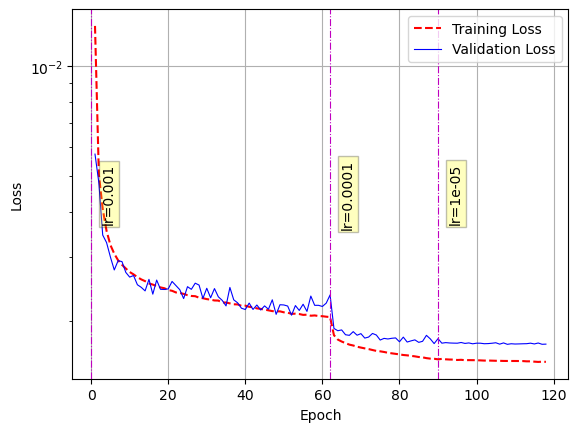

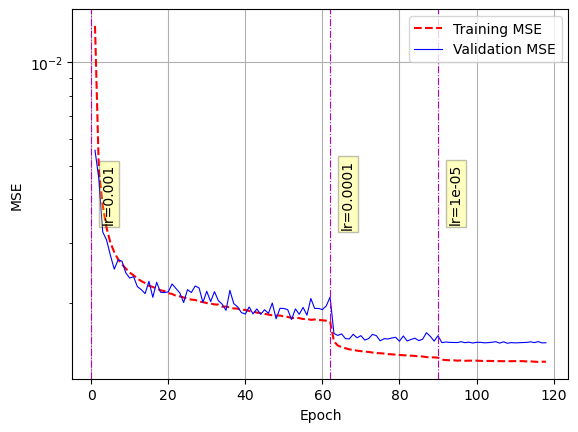

<Figure size 640x480 with 0 Axes>

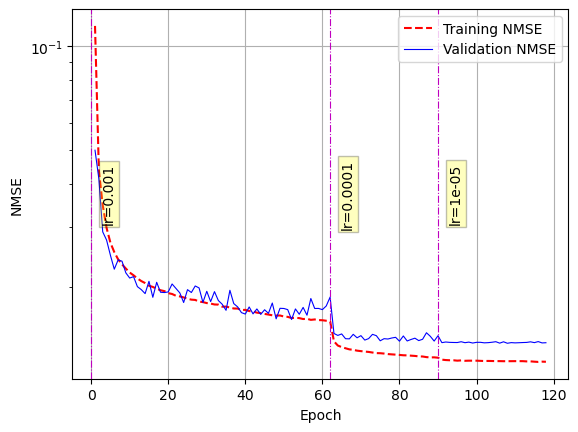

<Figure size 640x480 with 0 Axes>

In [32]:
# plotting losses
dir_name_plot = dir_name_ae + '/plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_plot + '{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


fig, ax = plot_losses(
    training_loss=train_MSE_hist,
    val_loss=val_MSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training MSE', 'Validation MSE'],
    xlabel='Epoch',
    ylabel='MSE',
)
plt.savefig(dir_name_plot+'/MSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


fig, ax = plot_losses(
    training_loss=train_NMSE_hist,
    val_loss=val_NMSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training NMSE', 'Validation NMSE'],
    xlabel='Epoch',
    ylabel='NMSE',
)
plt.savefig(dir_name_plot+'/NMSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()

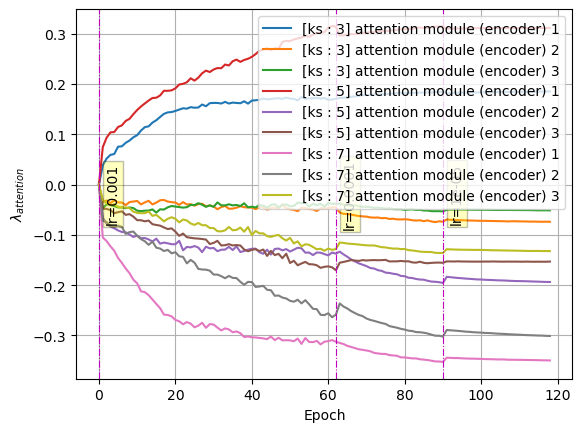

<Figure size 640x480 with 0 Axes>

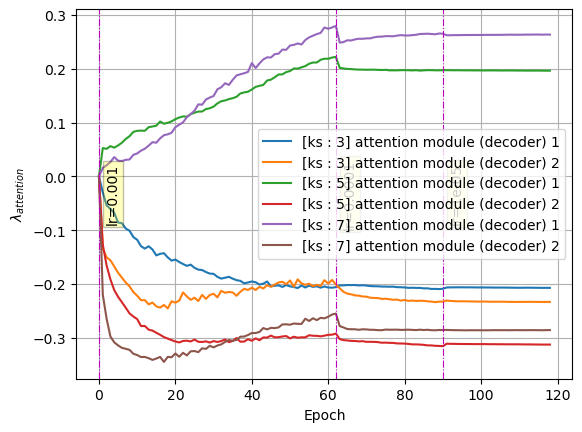

<Figure size 640x480 with 0 Axes>

In [33]:
if use_attention_module == True:
    # plotting encoder attention lambdas
    plot_lst = []
    legend_lst = []
    for ks_i in range(len(ae_net.kernel_size)):
        for i in range(len(ae_net.encoder_attention_modules_list[ks_i])):
            key = '{}__encoder_attention_module_{}_lambda'.format(ks_i, i)
            plot_lst.append(encoder_attention_lambdas[key])
            legend_lst.append(
                "[ks : {}] attention module (encoder) {}".format(
                    int(ae_net.kernel_size[ks_i]),
                    i+1
                )
            )
    fig, ax = plot_losses(
        training_loss=plot_lst[0],
        val_loss=None,
        more_plot_arrs_lst=plot_lst[1:] if len(plot_lst)>1 else [],
        lr_change=lr_change,
        learning_rate_list=learning_rate_list,
        legend_list=legend_lst,
        xlabel='Epoch',
        ylabel=r"$\lambda_{attention}$",
        plot_type='plot',
        traininglossplot_args=[],
        traininglossplot_kwargs={},
        epoch_count_begin=0,
        epoch_count_end=len(plot_lst[0])-1,
    )
    plt.savefig(dir_name_plot+'/attention_lambdas_encoder.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.clf()
    
    # plotting decoder attention lambdas
    plot_lst = []
    legend_lst = []
    for ks_i in range(len(ae_net.kernel_size)):
        for i in range(len(ae_net.decoder_attention_modules_list[ks_i])):
            key = '{}__decoder_attention_module_{}_lambda'.format(ks_i, i)
            plot_lst.append(decoder_attention_lambdas[key])
            legend_lst.append(
                "[ks : {}] attention module (decoder) {}".format(
                    int(ae_net.kernel_size[ks_i]),
                    i+1
                )
            )
    fig, ax = plot_losses(
        training_loss=plot_lst[0],
        val_loss=None,
        more_plot_arrs_lst=plot_lst[1:] if len(plot_lst)>1 else [],
        lr_change=lr_change,
        learning_rate_list=learning_rate_list,
        legend_list=legend_lst,
        xlabel='Epoch',
        ylabel=r"$\lambda_{attention}$",
        plot_type='plot',
        traininglossplot_args=[],
        traininglossplot_kwargs={},
        epoch_count_begin=0,
        epoch_count_end=len(plot_lst[0])-1,
    )
    plt.savefig(dir_name_plot+'/attention_lambdas_decoder.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.clf()

# POD Comparison

In [34]:
# pod_training_data = np.empty(shape=(training_data.shape[0], training_data.shape[1]*training_data.shape[2]*training_data.shape[3]))
# pod_training_data[:, :] = np.reshape(training_data, (training_data.shape[0], training_data.shape[1]*training_data.shape[2]*training_data.shape[3]))

# pod_centering_means = np.mean(pod_training_data, axis=0)
# pod_mean_centered_data = pod_training_data - pod_centering_means

In [35]:
# C = np.transpose(pod_mean_centered_data) @ pod_mean_centered_data
# C /= pod_mean_centered_data.shape[0] - 1

In [36]:
# eigenvals, eigenvecs = np.linalg.eig(C)

In [37]:
# abs_eigenvals = np.abs(eigenvals)
# idx = np.argsort(abs_eigenvals)

In [38]:
# idx = idx[::-1]
# W = eigenvecs[:, idx[0:4*4*enc_filters[-1]]]

In [39]:
# reconstructed_val_data = val_data.reshape(val_data.shape[0], training_data.shape[1]*training_data.shape[2]*training_data.shape[3]) @ W @ W.transpose()
# reconstructed_val_data = np.reshape(reconstructed_val_data, val_data.shape)

In [40]:
# val_recon_MSE = np.reshape((reconstructed_val_data - val_data)**2, (val_data.shape[0], training_data.shape[1]*training_data.shape[2]*training_data.shape[3]))
# val_recon_MSE = np.mean(np.sum(val_recon_MSE, axis=1), axis=0)

In [41]:
# print(val_recon_MSE, val_recon_MSE/np.sum(time_stddev**2), np.sum(time_stddev**2))

In [42]:
# abs_eigenvals[idx[0:4*4*2]]

In [43]:
s = ''
try:
    for ks_i in range(ae_net.num_kernel_sizes):
        for i in range(len(ae_net.encoder_layers_list[ks_i])):
            l = ae_net.encoder_layers_list[ks_i][i]
            name = str(l.name)
            if name.startswith('attention_module'):
                # print(i, name, l.lambda_att.numpy())
                s += 'i : {}, name : {}, lambda_att : {}\n'.format(i, name, l.lambda_att.numpy())
    
except:
    for i in range(len(ae_net.encoder_layers_list)):
        l = ae_net.encoder_layers_list[i]
        name = str(l.name)
        if name.startswith('attention_module'):
            # print(i, name, l.lambda_att.numpy())
            s += 'i : {}, name : {}, lambda_att : {}\n'.format(i, name, l.lambda_att.numpy())
print(s)

if s != '':
    with open(dir_name_ae + '/attention_lambdas_encoder.txt', 'w') as f:
        f.write(s)

i : 8, name : attention_module, lambda_att : 0.18444067239761353
i : 13, name : attention_module_1, lambda_att : -0.07292041182518005
i : 18, name : attention_module_2, lambda_att : -0.05044739320874214
i : 8, name : attention_module_3, lambda_att : 0.3113291263580322
i : 13, name : attention_module_4, lambda_att : -0.19142325222492218
i : 18, name : attention_module_5, lambda_att : -0.15317918360233307
i : 8, name : attention_module_6, lambda_att : -0.34834250807762146
i : 13, name : attention_module_7, lambda_att : -0.2978278398513794
i : 18, name : attention_module_8, lambda_att : -0.13116216659545898



In [44]:
s = ''
try:
    for ks_i in range(ae_net.num_kernel_sizes):
        for i in range(len(ae_net.decoder_layers_list[ks_i])):
            l = ae_net.decoder_layers_list[ks_i][i]
            name = str(l.name)
            if name.startswith('attention_module'):
                # print(i, name, l.lambda_att.numpy())
                s += 'i : {}, name : {}, lambda_att : {}\n'.format(i, name, l.lambda_att.numpy())
except:
    for i in range(len(ae_net.decoder_layers_list)):
        l = ae_net.decoder_layers_list[i]
        name = str(l.name)
        if name.startswith('attention_module'):
            # print(i, name, l.lambda_att.numpy())
            s += 'i : {}, name : {}, lambda_att : {}\n'.format(i, name, l.lambda_att.numpy())
print(s)

if s != '':
    with open(dir_name_ae + '/attention_lambdas_decoder.txt', 'w') as f:
        f.write(s)

i : 5, name : attention_module_9, lambda_att : -0.20700472593307495
i : 11, name : attention_module_10, lambda_att : -0.2333356738090515
i : 5, name : attention_module_11, lambda_att : 0.19681739807128906
i : 11, name : attention_module_12, lambda_att : -0.31228402256965637
i : 5, name : attention_module_13, lambda_att : 0.2633631229400635
i : 11, name : attention_module_14, lambda_att : -0.2860319912433624



In [45]:
try:
    s =  'ENCODED VECTOR WEIGHTS\n'
    s += '----------------------\n'
    for ks_i in range(ae_net.num_kernel_sizes):
        s += 'i : {:02d} -- kernel_size : {:02d} -- {:.5f}\n'.format(ks_i, ae_net.kernel_size[ks_i], ae_net.encoded_vec_weights[ks_i].value())
    s += '\n'
    s +=  'DECODED VECTOR WEIGHTS\n'
    s += '----------------------\n'
    for ks_i in range(ae_net.num_kernel_sizes):
        s += 'i : {:02d} -- kernel_size : {:02d} -- {:.5f}\n'.format(ks_i, ae_net.kernel_size[ks_i], ae_net.decoded_vec_weights[ks_i].value())
    print(s)
    with open(dir_name_ae + '/encoded_decoded_vec_weights.txt', 'w') as f:
        f.write(s)
except:
    pass

In [46]:
try:
    for ks_i in range(ae_net.num_kernel_sizes):
        for i in range(len(ae_net.encoder_layers_list[ks_i])):
            l = ae_net.encoder_layers_list[ks_i][i]
            name = str(l.name)
            if name.startswith('periodic_padding'):
                print(i, name, l.M_mat)
except:
    for i in range(len(ae_net.encoder_layers_list)):
        l = ae_net.encoder_layers_list[i]
        name = str(l.name)
        if name.startswith('periodic_padding'):
            print(i, name, l.M_mat)

0 periodic_padding <tf.Variable 'periodic_padding/M_mat:0' shape=(50, 50) dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)>
4 periodic_padding_1 <tf.Variable 'periodic_padding_1/M_mat:0' shape=(26, 24) dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.,

In [47]:
try:
    for ks_i in range(ae_net.num_kernel_sizes):
        for i in range(len(ae_net.decoder_layers_list[ks_i])):
            l = ae_net.decoder_layers_list[ks_i][i]
            name = str(l.name)
            if name.startswith('periodic_padding'):
                print(i, name, l.M_mat)
except:
    for i in range(len(ae_net.decoder_layers_list)):
        l = ae_net.decoder_layers_list[i]
        name = str(l.name)
        if name.startswith('periodic_padding'):
            print(i, name, l.M_mat)

0 periodic_padding_15 <tf.Variable 'periodic_padding_15/M_mat:0' shape=(5, 3) dtype=float32, numpy=
array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)>
6 periodic_padding_16 <tf.Variable 'periodic_padding_16/M_mat:0' shape=(5, 3) dtype=float32, numpy=
array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)>
12 periodic_padding_17 <tf.Variable 'periodic_padding_17/M_mat:0' shape=(8, 6) dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)>
17 periodic_padding_18 <tf.Variable 'periodic_padding_18/M_mat:0' shape=(14, 12) dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0.